In [1]:
import pickle
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
USER_DICT_PKL   = 'user_dict.pkl'
TRAIN_USERS_PKL = 'train_users.pkl'
TEST_USERS_PKL  = 'test_users.pkl'

with open(USER_DICT_PKL,   'rb') as f:
    user_dict   = pickle.load(f)
with open(TRAIN_USERS_PKL, 'rb') as f:
    train_users = pickle.load(f)
with open(TEST_USERS_PKL,  'rb') as f:
    test_users  = pickle.load(f)

all_train_users = sorted(set(user_dict) - set(test_users))

LIKE_THRESHOLD = 4

n_movies = user_dict[all_train_users[0]].shape[0]


In [3]:
def build_matrix(uids):
    M = np.empty((len(uids), n_movies), dtype=float)
    M[:] = np.nan
    for i, uid in enumerate(uids):
        M[i] = user_dict[uid]
    return M

def binarize(X):
    return np.where(
        np.isnan(X),
        np.nan,
        (X >= LIKE_THRESHOLD).astype(int)
    )

In [4]:
sizes = [50, 100, 500, 1000, 2500, len(all_train_users)]
results = []
rng = np.random.default_rng(0)

for sz in sizes:
    train_u = list(rng.choice(all_train_users, size=sz, replace=False))
    
    Xtrb = binarize(build_matrix(train_u))
    Xteb = binarize(build_matrix(test_users))
    
    t0 = time.time()
    counts = np.sum(~np.isnan(Xtrb), axis=0)
    sums   = np.nansum(Xtrb, axis=0)
    p_i = np.divide(
        sums,
        counts,
        out=np.full_like(sums, 0.5),
        where=(counts > 0)
    )
    train_t = time.time() - t0
    
    preds = (p_i >= 0.5).astype(int)
    t1 = time.time()
    total_hidden = correct = 0
    for row in Xteb:
        idx = np.where(~np.isnan(row))[0]
        if idx.size:
            perm   = rng.permutation(idx)
            cutoff = int(np.ceil(0.7 * len(perm)))
            hidden = perm[cutoff:]
            actual = row[hidden].astype(int)
            guess  = preds[hidden]
            correct    += (guess == actual).sum()
            total_hidden += len(hidden)
    pred_t   = time.time() - t1
    acc      = correct / total_hidden
    err_rate = 1 - acc
    
    pi_clip = np.clip(p_i, 1e-10, 1-1e-10)
    total_logp = total_obs = 0
    for row in Xteb:
        idx = np.where(~np.isnan(row))[0]
        if idx.size:
            x  = row[idx].astype(int)
            p  = pi_clip[idx]
            total_logp += (x * np.log(p) + (1-x) * np.log(1-p)).sum()
            total_obs  += idx.size
    pll = total_logp / total_obs
    
    results.append({
        'train_size': sz,
        'train_time_s': train_t,
        'pred_time_s': pred_t,
        'accuracy': acc,
        'error_rate': err_rate,
        'pseudolikelihood': pll
    })

df = pd.DataFrame(results)
df

,train_size,train_time_s,pred_time_s,accuracy,error_rate,pseudolikelihood
0,50,0.000997,0.023041,0.638524,0.361476,-2.098876
1,100,0.001996,0.023388,0.642124,0.357876,-1.586494
2,500,0.015083,0.034026,0.677474,0.322526,-0.754262
3,1000,0.021911,0.023193,0.680098,0.319902,-0.637205
4,2500,0.053657,0.023993,0.681659,0.318341,-0.607284
5,5040,0.116143,0.024253,0.687168,0.312832,-0.597498


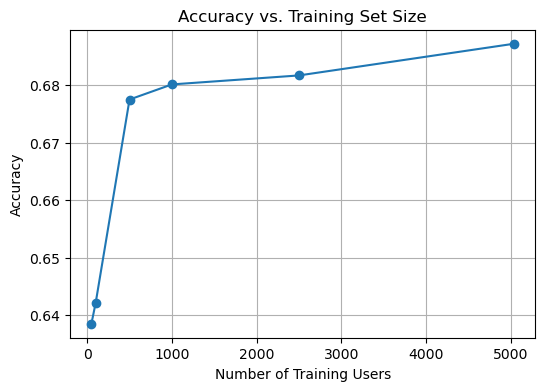

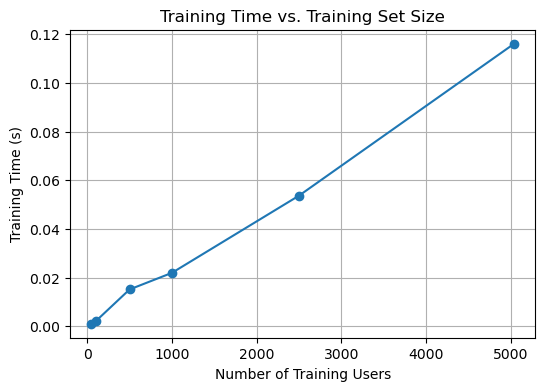

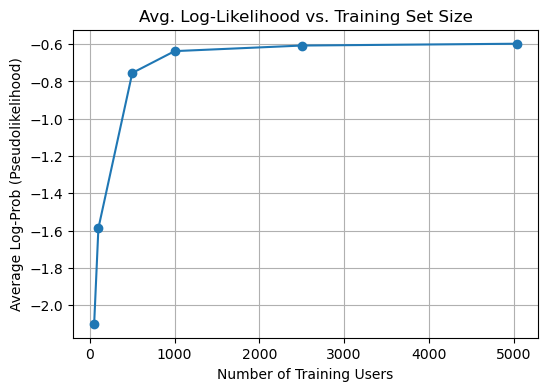

In [5]:
plt.figure(figsize=(6,4))
plt.plot(df.train_size, df.accuracy, marker='o', linestyle='-')
plt.title('Accuracy vs. Training Set Size')
plt.xlabel('Number of Training Users')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(df.train_size, df.train_time_s, marker='o', linestyle='-')
plt.title('Training Time vs. Training Set Size')
plt.xlabel('Number of Training Users')
plt.ylabel('Training Time (s)')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(df.train_size, df.pseudolikelihood, marker='o', linestyle='-')
plt.title('Avg. Log-Likelihood vs. Training Set Size')
plt.xlabel('Number of Training Users')
plt.ylabel('Average Log-Prob (Pseudolikelihood)')
plt.grid(True)
plt.show()